# Pipeline Algoritma Genetik untuk MDVRP dengan SPKLU

Pipeline lengkap untuk menyelesaikan Multi-Depot Vehicle Routing Problem (MDVRP) dengan Station Pengisian Kendaraan Listrik Umum (SPKLU) menggunakan Algoritma Genetik.

## Komponen:
1. **Inisialisasi Populasi** - Generate populasi awal
2. **Fitness Function** - Evaluasi kualitas solusi
3. **Selection** - Elitism + Tournament Selection
4. **Crossover** - Best Cost Route Crossover (BCRC)
5. **Mutation** - Inter-depot & Intra-depot Mutation
6. **Evolusi** - Iterasi hingga konvergen

In [2]:
# Import library yang dibutuhkan
import random
import math
import csv
import copy
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 1. Modul Konfigurasi & Load Data

In [3]:
def load_nodes_from_csv(filename):
    """Load data node dari file CSV"""
    nodes_data = {}
    with open(filename, 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file, delimiter=';')
        for row in reader:
            try:
                index = int(row['index'])
                x = float(row['x'].replace(',', '.'))
                y = float(row['y'].replace(',', '.'))
                demand = int(row['Demand'])
                nodes_data[index] = {'x': x, 'y': y, 'demand': demand}
            except (ValueError, KeyError):
                continue
    return nodes_data

class MDVRPConfig:
    """Konfigurasi MDVRP"""
    def __init__(self, csv_filename, depot_indices, spklu_indices=None, 
                 customer_indices=None, vehicle_capacity=500):
        self.nodes_data = load_nodes_from_csv(csv_filename)
        self.depot_indices = depot_indices
        self.spklu_indices = spklu_indices if spklu_indices else []
        self.vehicle_capacity = vehicle_capacity
        
        # Identifikasi customer
        if customer_indices is not None:
            self.customer_indices = [idx for idx in customer_indices if idx in self.nodes_data]
        else:
            all_indices = set(self.nodes_data.keys())
            depot_set = set(depot_indices)
            spklu_set = set(self.spklu_indices)
            self.customer_indices = list(all_indices - depot_set - spklu_set)
    
    def get_node_info(self, index):
        """Mendapatkan informasi node"""
        if index in self.nodes_data:
            node = self.nodes_data[index]
            return node['x'], node['y'], node['demand']
        return None
    
    def get_demand(self, index):
        """Mendapatkan demand dari node"""
        if index in self.depot_indices or index in self.spklu_indices:
            return 0
        if index in self.nodes_data:
            return self.nodes_data[index]['demand']
        return 0
    
    def calculate_distance(self, index1, index2):
        """Menghitung jarak Euclidean"""
        if index1 not in self.nodes_data or index2 not in self.nodes_data:
            return float('inf')
        
        node1 = self.nodes_data[index1]
        node2 = self.nodes_data[index2]
        
        dx = node1['x'] - node2['x']
        dy = node1['y'] - node2['y']
        
        return math.sqrt(dx**2 + dy**2)

print("✓ Konfigurasi & Load Data module ready")

✓ Konfigurasi & Load Data module ready


## 2. Modul Generate Populasi Awal

In [4]:
def generate_initial_population(config, pop_size=10, use_spklu=True):
    """Generate populasi awal dengan delimiter encoding"""
    population = []
    population_set = set()
    
    max_attempts = pop_size * 10
    attempts = 0
    
    while len(population) < pop_size and attempts < max_attempts:
        attempts += 1
        chromosome = []
        remaining_customers = config.customer_indices.copy()
        random.shuffle(remaining_customers)
        
        first_route = True
        while remaining_customers:
            start_depot = random.choice(config.depot_indices)
            end_depot = random.choice(config.depot_indices)
            
            route_customers = []
            current_demand = 0
            
            for customer in remaining_customers[:]:
                customer_demand = config.get_demand(customer)
                if current_demand + customer_demand <= config.vehicle_capacity:
                    route_customers.append(customer)
                    current_demand += customer_demand
            
            if not route_customers and remaining_customers:
                route_customers.append(remaining_customers[0])
            
            if not route_customers:
                break
            
            # Tambahkan delimiter sebelum route (kecuali route pertama)
            if not first_route:
                chromosome.append('|')
            
            # Bangun route dengan format: Depot -> Customers -> [SPKLU] -> Depot
            chromosome.append(start_depot)
            chromosome.extend(route_customers)
            if use_spklu and config.spklu_indices:
                chromosome.append(random.choice(config.spklu_indices))
            chromosome.append(end_depot)
            
            first_route = False
            
            for customer in route_customers:
                remaining_customers.remove(customer)
        
        if len(remaining_customers) == 0 and len(chromosome) > 0:
            chromosome_tuple = tuple(chromosome)
            if chromosome_tuple not in population_set:
                population.append(chromosome)
                population_set.add(chromosome_tuple)
    
    return population

print("✓ Generate populasi module ready")

✓ Generate populasi module ready


## 3. Modul Fitness Function

In [5]:
def fitness_function(chromosome, config, battery_capacity=100, consumption_rate=1, 
                     charging_rate=1, w1=0.6, w2=0.4, verbose=False):
    """
    Menghitung fitness berdasarkan total jarak dan waktu charging
    - Fitness = w1 * D + w2 * C
    - Semakin kecil semakin baik
    """
    total_distance = 0
    total_charging_time = 0
    invalid_penalty = 999999
    
    # Split chromosome menjadi routes berdasarkan delimiter '|'
    routes = []
    current_route = []
    for gene in chromosome:
        if gene == '|':
            if current_route:
                routes.append(current_route)
                current_route = []
        else:
            current_route.append(gene)
    if current_route:
        routes.append(current_route)
    
    # Simulasi per rute
    for route in routes:
        battery = battery_capacity
        
        for i in range(len(route) - 1):
            a, b = route[i], route[i + 1]
            
            # Hitung jarak
            dist = config.calculate_distance(a, b)
            if dist == float('inf'):
                continue
            
            total_distance += dist
            needed_energy = dist * consumption_rate
            
            # Cek apakah di SPKLU
            if isinstance(a, int) and a in config.spklu_indices:
                # Hitung energi yang dibutuhkan sampai SPKLU/depot berikutnya
                energy_needed_to_next_station = 0
                for j in range(i, len(route) - 1):
                    u, v = route[j], route[j + 1]
                    edge_dist = config.calculate_distance(u, v)
                    if edge_dist != float('inf'):
                        energy_needed_to_next_station += edge_dist * consumption_rate
                    
                    # Berhenti jika ketemu SPKLU atau depot
                    if isinstance(v, int) and (v in config.spklu_indices or v in config.depot_indices):
                        break
                
                # Isi daya secukupnya
                required_energy = max(0, energy_needed_to_next_station - battery)
                charge_time = required_energy / charging_rate
                total_charging_time += charge_time
                battery += required_energy
                battery = min(battery, battery_capacity)
                
                if verbose:
                    print(f"  Charging at {a}: +{required_energy:.2f} energy, Time: {charge_time:.2f} min")
            
            # Cek apakah baterai cukup
            if battery < needed_energy:
                if verbose:
                    print(f"  Invalid: Battery insufficient from {a} to {b}")
                return invalid_penalty
            
            battery -= needed_energy
    
    # Normalisasi dan hitung fitness
    D = total_distance / 100.0
    C = total_charging_time / 100.0
    
    fitness = w1 * D + w2 * C
    return fitness

def calculate_population_fitness(population, config):
    """Menghitung fitness untuk seluruh populasi"""
    fitness_scores = []
    for chromosome in population:
        fitness = fitness_function(chromosome, config)
        fitness_scores.append(fitness)
    return fitness_scores

print("✓ Fitness function module ready")

✓ Fitness function module ready


## 4. Modul Selection (Elitism + Tournament)

In [6]:
def get_elites(population, fitness_scores, elite_size):
    """Memilih individu terbaik (elites)"""
    population_with_fitness = list(zip(population, fitness_scores))
    sorted_population = sorted(population_with_fitness, key=lambda x: x[1])
    elites = [individual for individual, fitness in sorted_population[:elite_size]]
    return elites

def run_tournament(population, fitness_scores, tournament_size):
    """Tournament selection"""
    tournament_indices = random.sample(range(len(population)), tournament_size)
    
    best_individual = None
    best_fitness = float('inf')
    
    for index in tournament_indices:
        individual = population[index]
        fitness = fitness_scores[index]
        
        if fitness < best_fitness:
            best_fitness = fitness
            best_individual = individual
    
    return best_individual

def selection(population, fitness_scores, elite_size, tournament_size):
    """Kombinasi Elitism dan Tournament Selection"""
    new_parents = []
    
    # Elitism: pertahankan individu terbaik
    elites = get_elites(population, fitness_scores, elite_size)
    new_parents.extend(elites)
    
    # Tournament selection untuk sisa populasi
    num_to_select = len(population) - elite_size
    for _ in range(num_to_select):
        parent = run_tournament(population, fitness_scores, tournament_size)
        new_parents.append(parent)
    
    return new_parents

print("✓ Selection module ready")

✓ Selection module ready


## 5. Modul Crossover (BCRC)

In [7]:
def split_routes(chrom):
    """Split chromosome by delimiter '|'"""
    routes = []
    cur = []
    for x in chrom:
        if x == "|":
            routes.append(cur)
            cur = []
        else:
            cur.append(x)
    routes.append(cur)
    return routes

def join_routes(routes):
    """Join routes back to encoding"""
    chrom = []
    for i, r in enumerate(routes):
        if i > 0:
            chrom.append("|")
        chrom.extend(r)
    return chrom

def remove_customer_routes(routes, customer):
    """Remove customer from all routes"""
    new_routes = []
    for r in routes:
        new_routes.append([x for x in r if x != customer])
    return new_routes

def get_distance_crossover(a, b, config):
    """Get distance untuk crossover"""
    return config.calculate_distance(a, b)

def insertion_cost(route, customer, config):
    """Hitung biaya insersi customer pada route"""
    if len(route) < 2:
        return 0, 0
    
    best_cost = float("inf")
    best_pos = None
    
    for i in range(len(route) - 1):
        a, b = route[i], route[i+1]
        cost_before = get_distance_crossover(a, b, config)
        cost_after = get_distance_crossover(a, customer, config) + get_distance_crossover(customer, b, config)
        delta = cost_after - cost_before
        
        if delta < best_cost:
            best_cost = delta
            best_pos = i + 1
    
    return best_cost, best_pos

def bcrc_crossover(chrom1, chrom2, config):
    """Best Cost Route Crossover"""
    p1 = copy.deepcopy(chrom1)
    p2 = copy.deepcopy(chrom2)
    
    routes1 = split_routes(p1)
    routes2 = split_routes(p2)
    
    # Pilih random customer (hanya customer, bukan depot/SPKLU)
    all_customers = []
    for r in routes1:
        for x in r:
            if isinstance(x, int) and x in config.customer_indices:
                all_customers.append(x)
    
    if not all_customers:
        return chrom2
    
    customer = random.choice(all_customers)
    
    # Remove customer dari parent2
    child_routes = remove_customer_routes(routes2, customer)
    
    # Cari posisi insersi terbaik
    best_global_cost = float("inf")
    best_route_idx = None
    best_insert_pos = None
    
    for idx, route in enumerate(child_routes):
        if len(route) < 2:
            continue
        cost, pos = insertion_cost(route, customer, config)
        if cost < best_global_cost:
            best_global_cost = cost
            best_route_idx = idx
            best_insert_pos = pos
    
    # Insert customer
    if best_route_idx is not None and best_insert_pos is not None:
        child_routes[best_route_idx].insert(best_insert_pos, customer)
    else:
        for idx, route in enumerate(child_routes):
            if len(route) >= 2:
                child_routes[idx].insert(1, customer)
                break
    
    return join_routes(child_routes)

def crossover_population(parents, config, crossover_rate=0.8):
    """Aplikasikan crossover pada populasi"""
    offspring = []
    
    for i in range(0, len(parents), 2):
        parent1 = parents[i]
        parent2 = parents[i+1] if i+1 < len(parents) else parents[0]
        
        if random.random() < crossover_rate:
            child1 = bcrc_crossover(parent1, parent2, config)
            child2 = bcrc_crossover(parent2, parent1, config)
            offspring.append(child1)
            offspring.append(child2)
        else:
            offspring.append(copy.deepcopy(parent1))
            offspring.append(copy.deepcopy(parent2))
    
    return offspring[:len(parents)]

print("✓ Crossover module ready")

✓ Crossover module ready


## 6. Modul Mutation (Inter-depot & Intra-depot)

In [8]:
def extract_routes_mutation(chromosome):
    """Extract routes dari chromosome"""
    routes = []
    current_route = []
    
    for gene in chromosome:
        if gene == '|':
            if current_route:
                if len(current_route) >= 2:
                    routes.append({
                        'depot': current_route[0],
                        'customers': current_route[1:-1],
                        'full_route': current_route.copy()
                    })
                current_route = []
        else:
            current_route.append(gene)
    
    if current_route and len(current_route) >= 2:
        routes.append({
            'depot': current_route[0],
            'customers': current_route[1:-1],
            'full_route': current_route.copy()
        })
    
    return routes

def rebuild_chromosome_from_routes(routes):
    """Rebuild chromosome dari routes"""
    chromosome = []
    for i, route in enumerate(routes):
        if i > 0:
            chromosome.append('|')
        chromosome.extend(route['full_route'])
    return chromosome

def intra_depot_mutation(chromosome):
    """Intra-depot mutation (swap, inversion, insertion)"""
    routes = extract_routes_mutation(chromosome)
    
    valid_routes = [route for route in routes if len(route['customers']) >= 2]
    
    if not valid_routes:
        return chromosome
    
    selected_route = random.choice(valid_routes)
    customers = selected_route['customers']
    
    mutation_type = random.choice(['swap', 'inversion', 'insertion'])
    
    if mutation_type == 'swap' and len(customers) >= 2:
        pos1, pos2 = random.sample(range(len(customers)), 2)
        customers[pos1], customers[pos2] = customers[pos2], customers[pos1]
        
    elif mutation_type == 'inversion' and len(customers) >= 2:
        start, end = sorted(random.sample(range(len(customers)), 2))
        customers[start:end+1] = list(reversed(customers[start:end+1]))
        
    elif mutation_type == 'insertion' and len(customers) >= 2:
        from_pos = random.randint(0, len(customers)-1)
        to_pos = random.randint(0, len(customers)-1)
        while to_pos == from_pos:
            to_pos = random.randint(0, len(customers)-1)
        
        customer_moved = customers.pop(from_pos)
        customers.insert(to_pos, customer_moved)
    
    # Update full_route
    selected_route['full_route'] = [selected_route['depot']] + customers + [selected_route['depot']]
    
    return rebuild_chromosome_from_routes(routes)

def apply_mutation(chromosome, config, mutation_probability=0.1):
    """Apply mutation dengan probabilitas tertentu"""
    if random.random() > mutation_probability:
        return chromosome
    
    # Untuk saat ini hanya gunakan intra-depot mutation
    return intra_depot_mutation(chromosome)

def mutate_population(population, config, mutation_rate=0.1):
    """Aplikasikan mutasi pada populasi"""
    mutated = []
    for chromosome in population:
        mutated_chrom = apply_mutation(chromosome, config, mutation_rate)
        mutated.append(mutated_chrom)
    return mutated

print("✓ Mutation module ready")

✓ Mutation module ready


## 7. Pipeline Utama Algoritma Genetik

In [9]:
def genetic_algorithm(config, 
                      pop_size=20,
                      max_generations=100,
                      elite_size=2,
                      tournament_size=3,
                      crossover_rate=0.8,
                      mutation_rate=0.1,
                      early_stop_generations=20,
                      verbose=True):
    """
    Pipeline lengkap Algoritma Genetik untuk MDVRP
    
    Parameters:
    -----------
    config : MDVRPConfig
        Konfigurasi problem
    pop_size : int
        Ukuran populasi
    max_generations : int
        Maksimum generasi
    elite_size : int
        Jumlah elite yang dipertahankan
    tournament_size : int
        Ukuran tournament selection
    crossover_rate : float
        Probabilitas crossover
    mutation_rate : float
        Probabilitas mutasi
    early_stop_generations : int
        Stop jika tidak ada improvement selama N generasi
    verbose : bool
        Print progress
        
    Returns:
    --------
    best_solution : list
        Solusi terbaik yang ditemukan
    best_fitness : float
        Fitness dari solusi terbaik
    history : dict
        History evolusi (best fitness, avg fitness per generasi)
    """
    
    # History untuk tracking
    history = {
        'best_fitness': [],
        'avg_fitness': [],
        'generation': []
    }
    
    # 1. Generate populasi awal
    if verbose:
        print("="*80)
        print("ALGORITMA GENETIK - MDVRP dengan SPKLU")
        print("="*80)
        print(f"\n[Generation 0] Generating initial population...")
    
    population = generate_initial_population(config, pop_size=pop_size, use_spklu=True)
    
    if verbose:
        print(f"✓ Initial population generated: {len(population)} chromosomes")
    
    # 2. Evaluasi fitness populasi awal
    fitness_scores = calculate_population_fitness(population, config)
    
    best_fitness_overall = min(fitness_scores)
    best_solution = population[fitness_scores.index(best_fitness_overall)]
    
    generations_without_improvement = 0
    
    if verbose:
        print(f"✓ Initial best fitness: {best_fitness_overall:.4f}")
        print(f"✓ Initial avg fitness: {np.mean(fitness_scores):.4f}\n")
    
    # 3. Evolusi
    for generation in range(1, max_generations + 1):
        
        # Selection
        parents = selection(population, fitness_scores, elite_size, tournament_size)
        
        # Crossover
        offspring = crossover_population(parents, config, crossover_rate)
        
        # Mutation
        offspring = mutate_population(offspring, config, mutation_rate)
        
        # Evaluasi offspring
        population = offspring
        fitness_scores = calculate_population_fitness(population, config)
        
        # Update best solution
        current_best_fitness = min(fitness_scores)
        current_avg_fitness = np.mean(fitness_scores)
        
        if current_best_fitness < best_fitness_overall:
            best_fitness_overall = current_best_fitness
            best_solution = population[fitness_scores.index(current_best_fitness)]
            generations_without_improvement = 0
            
            if verbose:
                print(f"[Gen {generation:3d}] ✨ NEW BEST! Fitness: {best_fitness_overall:.4f} | Avg: {current_avg_fitness:.4f}")
        else:
            generations_without_improvement += 1
            
            if verbose and generation % 10 == 0:
                print(f"[Gen {generation:3d}] Best: {best_fitness_overall:.4f} | Avg: {current_avg_fitness:.4f}")
        
        # Simpan history
        history['generation'].append(generation)
        history['best_fitness'].append(best_fitness_overall)
        history['avg_fitness'].append(current_avg_fitness)
        
        # Early stopping
        if generations_without_improvement >= early_stop_generations:
            if verbose:
                print(f"\n⚠ Early stopping: No improvement for {early_stop_generations} generations")
            break
    
    if verbose:
        print("\n" + "="*80)
        print("OPTIMIZATION COMPLETE")
        print("="*80)
        print(f"Final Best Fitness: {best_fitness_overall:.4f}")
        print(f"Generations Run: {generation}")
    
    return best_solution, best_fitness_overall, history

print("✓ Genetic Algorithm pipeline ready")

✓ Genetic Algorithm pipeline ready


## 8. Fungsi Visualisasi & Analisis Hasil

In [10]:
def plot_convergence(history):
    """Plot grafik konvergensi algoritma"""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.plot(history['generation'], history['best_fitness'], 
            label='Best Fitness', linewidth=2, marker='o', markersize=4)
    ax.plot(history['generation'], history['avg_fitness'], 
            label='Average Fitness', linewidth=2, marker='s', markersize=4, alpha=0.7)
    
    ax.set_xlabel('Generation', fontsize=12)
    ax.set_ylabel('Fitness', fontsize=12)
    ax.set_title('Genetic Algorithm Convergence', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_routes(solution, config):
    """Visualisasi rute pada peta"""
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Parse routes dari solution
    routes = []
    current_route = []
    for gene in solution:
        if gene == '|':
            if current_route:
                routes.append(current_route)
                current_route = []
        else:
            current_route.append(gene)
    if current_route:
        routes.append(current_route)
    
    # Warna untuk setiap route
    colors = plt.cm.Set3(np.linspace(0, 1, len(routes)))
    
    # Plot setiap route
    for idx, route in enumerate(routes):
        route_x = []
        route_y = []
        
        for node in route:
            if node in config.nodes_data:
                route_x.append(config.nodes_data[node]['x'])
                route_y.append(config.nodes_data[node]['y'])
        
        # Plot route line
        ax.plot(route_x, route_y, color=colors[idx], linewidth=2, 
                alpha=0.7, label=f'Route {idx+1}')
        
        # Plot nodes
        for i, node in enumerate(route):
            if node not in config.nodes_data:
                continue
                
            x = config.nodes_data[node]['x']
            y = config.nodes_data[node]['y']
            
            if node in config.depot_indices:
                ax.scatter(x, y, c='red', s=200, marker='s', 
                          edgecolors='black', linewidths=2, zorder=5)
                ax.text(x, y-5, f'D{node}', ha='center', fontsize=9, fontweight='bold')
            elif node in config.spklu_indices:
                ax.scatter(x, y, c='green', s=150, marker='^', 
                          edgecolors='black', linewidths=2, zorder=5)
                ax.text(x, y-5, f'S{node}', ha='center', fontsize=9, fontweight='bold')
            else:
                ax.scatter(x, y, c='blue', s=80, marker='o', 
                          edgecolors='black', linewidths=1, zorder=4)
    
    ax.set_xlabel('X Coordinate', fontsize=12)
    ax.set_ylabel('Y Coordinate', fontsize=12)
    ax.set_title('Vehicle Routes Visualization', fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def analyze_solution(solution, config):
    """Analisis detail solusi"""
    print("\n" + "="*80)
    print("SOLUTION ANALYSIS")
    print("="*80)
    
    # Parse routes
    routes = []
    current_route = []
    for gene in solution:
        if gene == '|':
            if current_route:
                routes.append(current_route)
                current_route = []
        else:
            current_route.append(gene)
    if current_route:
        routes.append(current_route)
    
    total_distance = 0
    total_customers = 0
    
    print(f"\nNumber of Routes: {len(routes)}")
    print("-"*80)
    
    for idx, route in enumerate(routes):
        route_distance = 0
        route_demand = 0
        customers_in_route = []
        
        # Hitung jarak dan demand
        for i in range(len(route) - 1):
            dist = config.calculate_distance(route[i], route[i+1])
            if dist != float('inf'):
                route_distance += dist
        
        for node in route:
            demand = config.get_demand(node)
            if demand > 0:
                route_demand += demand
                customers_in_route.append(node)
        
        total_distance += route_distance
        total_customers += len(customers_in_route)
        
        # Display route info
        route_str = " -> ".join([str(n) for n in route])
        utilization = (route_demand / config.vehicle_capacity) * 100
        
        print(f"\nRoute {idx+1}:")
        print(f"  Path: {route_str}")
        print(f"  Customers: {len(customers_in_route)} nodes")
        print(f"  Distance: {route_distance:.2f}")
        print(f"  Demand: {route_demand}/{config.vehicle_capacity} ({utilization:.1f}%)")
    
    print("\n" + "-"*80)
    print(f"TOTAL DISTANCE: {total_distance:.2f}")
    print(f"TOTAL CUSTOMERS SERVED: {total_customers}")
    print(f"AVERAGE DISTANCE PER ROUTE: {total_distance/len(routes):.2f}")
    print("="*80)

print("✓ Visualization & analysis module ready")

✓ Visualization & analysis module ready


## 9. Eksekusi Pipeline - Konfigurasi & Run

In [11]:
# ===== KONFIGURASI PROBLEM =====
CSV_FILE = 'data_koordinat.csv'
DEPOT_INDICES = [1, 42]      # Indeks depot
SPKLU_INDICES = [82, 122]    # Indeks SPKLU

# Pilihan customer - pilih salah satu:
# Option 1: Custom customer
CUSTOMER_INDICES = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Option 2: Ambil N customer pertama (uncomment untuk pakai)
# N_CUSTOMERS = 20
# all_nodes = load_nodes_from_csv(CSV_FILE)
# CUSTOMER_INDICES = [idx for idx in sorted(all_nodes.keys()) 
#                     if idx not in DEPOT_INDICES and idx not in SPKLU_INDICES][:N_CUSTOMERS]

VEHICLE_CAPACITY = 100  # Kapasitas kendaraan

# ===== KONFIGURASI ALGORITMA GENETIK =====
POP_SIZE = 20               # Ukuran populasi
MAX_GENERATIONS = 100       # Maksimum generasi
ELITE_SIZE = 2              # Jumlah elite
TOURNAMENT_SIZE = 3         # Ukuran tournament
CROSSOVER_RATE = 0.8        # Probabilitas crossover
MUTATION_RATE = 0.1         # Probabilitas mutasi
EARLY_STOP_GEN = 20         # Early stopping

# Inisialisasi konfigurasi
config = MDVRPConfig(
    csv_filename=CSV_FILE,
    depot_indices=DEPOT_INDICES,
    spklu_indices=SPKLU_INDICES,
    customer_indices=CUSTOMER_INDICES,
    vehicle_capacity=VEHICLE_CAPACITY
)

print("="*80)
print("KONFIGURASI PROBLEM")
print("="*80)
print(f"Data File: {CSV_FILE}")
print(f"Depots: {DEPOT_INDICES}")
print(f"SPKLU: {SPKLU_INDICES}")
print(f"Customers: {len(config.customer_indices)} nodes")
print(f"Vehicle Capacity: {VEHICLE_CAPACITY}")
print(f"\nTotal Demand: {sum(config.get_demand(c) for c in config.customer_indices)}")
print(f"Min Routes Needed: {math.ceil(sum(config.get_demand(c) for c in config.customer_indices) / VEHICLE_CAPACITY)}")
print("\n" + "="*80)
print("ALGORITMA GENETIK PARAMETERS")
print("="*80)
print(f"Population Size: {POP_SIZE}")
print(f"Max Generations: {MAX_GENERATIONS}")
print(f"Elite Size: {ELITE_SIZE}")
print(f"Tournament Size: {TOURNAMENT_SIZE}")
print(f"Crossover Rate: {CROSSOVER_RATE}")
print(f"Mutation Rate: {MUTATION_RATE}")
print(f"Early Stop: {EARLY_STOP_GEN} generations")
print("="*80)

KONFIGURASI PROBLEM
Data File: data_koordinat.csv
Depots: [1, 42]
SPKLU: [82, 122]
Customers: 9 nodes
Vehicle Capacity: 100

Total Demand: 170
Min Routes Needed: 2

ALGORITMA GENETIK PARAMETERS
Population Size: 20
Max Generations: 100
Elite Size: 2
Tournament Size: 3
Crossover Rate: 0.8
Mutation Rate: 0.1
Early Stop: 20 generations


In [12]:
# ===== JALANKAN ALGORITMA GENETIK =====
best_solution, best_fitness, history = genetic_algorithm(
    config=config,
    pop_size=POP_SIZE,
    max_generations=MAX_GENERATIONS,
    elite_size=ELITE_SIZE,
    tournament_size=TOURNAMENT_SIZE,
    crossover_rate=CROSSOVER_RATE,
    mutation_rate=MUTATION_RATE,
    early_stop_generations=EARLY_STOP_GEN,
    verbose=True
)

ALGORITMA GENETIK - MDVRP dengan SPKLU

[Generation 0] Generating initial population...
✓ Initial population generated: 20 chromosomes
✓ Initial best fitness: 999999.0000
✓ Initial avg fitness: 999999.0000

[Gen  10] Best: 999999.0000 | Avg: 999999.0000
[Gen  20] Best: 999999.0000 | Avg: 999999.0000

⚠ Early stopping: No improvement for 20 generations

OPTIMIZATION COMPLETE
Final Best Fitness: 999999.0000
Generations Run: 20
[Gen  20] Best: 999999.0000 | Avg: 999999.0000

⚠ Early stopping: No improvement for 20 generations

OPTIMIZATION COMPLETE
Final Best Fitness: 999999.0000
Generations Run: 20


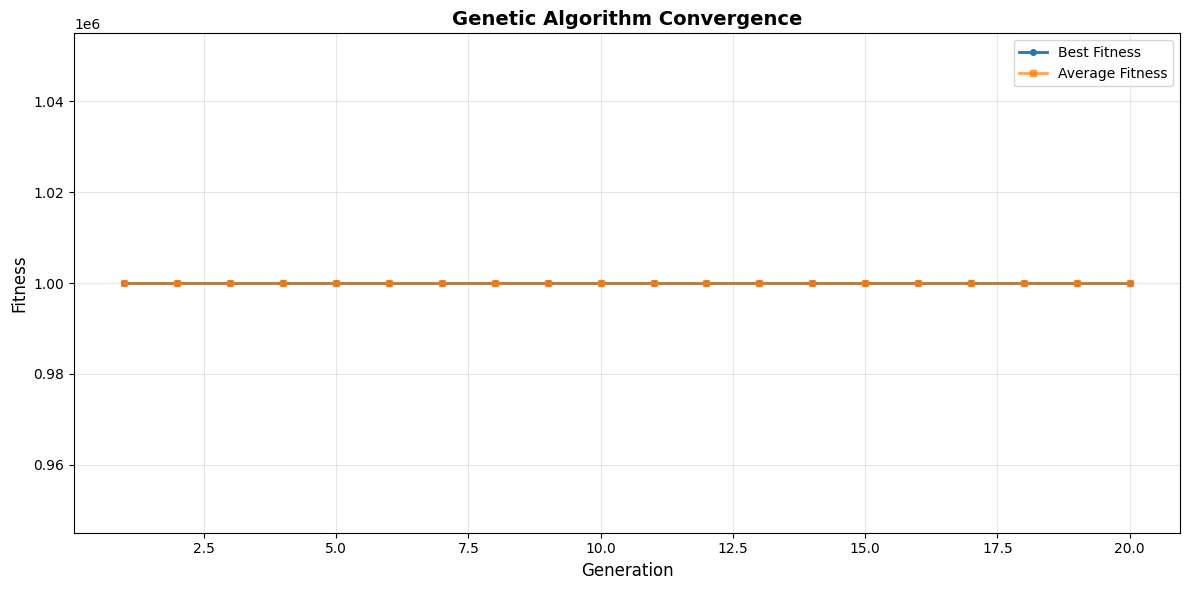

In [13]:
# ===== VISUALISASI HASIL =====
# Plot konvergensi
plot_convergence(history)

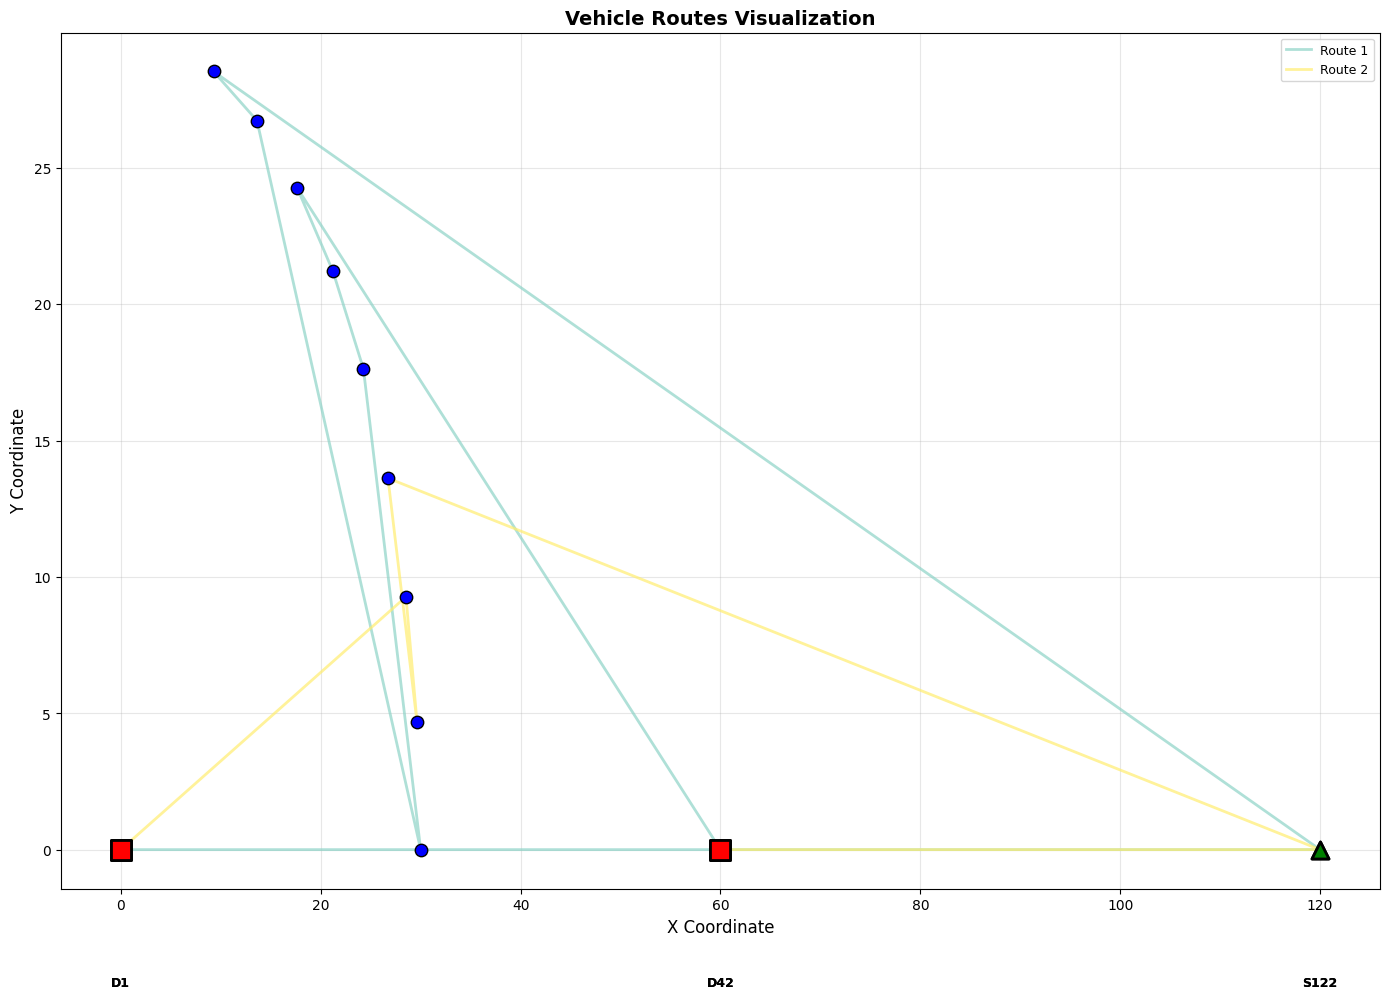

In [14]:
# ===== VISUALISASI RUTE =====
plot_routes(best_solution, config)

In [15]:
# ===== ANALISIS DETAIL SOLUSI =====
analyze_solution(best_solution, config)


SOLUTION ANALYSIS

Number of Routes: 2
--------------------------------------------------------------------------------

Route 1:
  Path: 42 -> 8 -> 7 -> 6 -> 2 -> 9 -> 10 -> 122 -> 1
  Customers: 6 nodes
  Distance: 347.19
  Demand: 100/100 (100.0%)

Route 2:
  Path: 1 -> 4 -> 3 -> 5 -> 122 -> 42
  Customers: 3 nodes
  Distance: 198.35
  Demand: 70/100 (70.0%)

--------------------------------------------------------------------------------
TOTAL DISTANCE: 545.54
TOTAL CUSTOMERS SERVED: 9
AVERAGE DISTANCE PER ROUTE: 272.77


## 10. Simpan Hasil (Opsional)

In [ ]:
# Simpan solusi terbaik ke file
import json
from datetime import datetime

def save_solution(solution, fitness, history, config, filename=None):
    """Simpan hasil ke file JSON"""
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"solution_{timestamp}.json"
    
    # Parse routes
    routes = []
    current_route = []
    for gene in solution:
        if gene == '|':
            if current_route:
                routes.append(current_route)
                current_route = []
        else:
            current_route.append(gene)
    if current_route:
        routes.append(current_route)
    
    result = {
        'timestamp': datetime.now().isoformat(),
        'configuration': {
            'depots': DEPOT_INDICES,
            'spklu': SPKLU_INDICES,
            'num_customers': len(config.customer_indices),
            'vehicle_capacity': VEHICLE_CAPACITY
        },
        'ga_parameters': {
            'population_size': POP_SIZE,
            'max_generations': MAX_GENERATIONS,
            'elite_size': ELITE_SIZE,
            'tournament_size': TOURNAMENT_SIZE,
            'crossover_rate': CROSSOVER_RATE,
            'mutation_rate': MUTATION_RATE
        },
        'solution': {
            'chromosome': solution,
            'routes': [[int(n) if isinstance(n, int) else n for n in route] for route in routes],
            'fitness': fitness,
            'num_routes': len(routes)
        },
        'history': {
            'generations': history['generation'],
            'best_fitness': history['best_fitness'],
            'avg_fitness': history['avg_fitness']
        }
    }
    
    with open(filename, 'w') as f:
        json.dump(result, f, indent=2)
    
    print(f"✓ Solution saved to: {filename}")
    return filename

# Uncomment untuk menyimpan hasil
# save_solution(best_solution, best_fitness, history, config)